# Estimating under-ice positions with the terrain-following (Yamazaki + 2020) toolbox

## Accessing the ftp server to download the argo prof netcdf file
First access the coriolis ftp server and download the "prof.nc" file:

In [1]:
# Import library
from ftplib import FTP

# Set user name and password
username = 'anonymous'
password = ''

# Connect to the ftp server
ftp = FTP('ftp.ifremer.fr',username,password)

# List the files or directories
#ftp.retrlines('LIST')

# Change directory to the product we want (Argo DAC)
ftp.cwd('ifremer/argo/dac/coriolis/')


'250 Directory successfully changed.'

Access the directory of the float (WMO number) and download the prof.nc file

In [2]:
wmo=str(7900549)

# Change directory to the float you want
ftp.cwd(wmo)

# Set the name of the file to download
filename=wmo+ '_prof.nc'

# Download the file
ftp.retrbinary("RETR " + filename ,open(filename, 'wb').write)

'226 Transfer complete.'

## Excecuting terrain-following code
Here we run different scripts in the terrain-following repository (I don't know how to call them from here so I just copy and paste the code)
https://github.com/euroargodev/terrain-following
I modified: paths, lines that retrieved warnings (SettingWithCopyWarning) and the listing of netcdf files (to read only one specified file)

In [3]:
# https://github.com/euroargodev/terrain-following/blob/main/nc2csv.py
# nc2csv.py
### This code extracts the trajectry of Argo data
### and divides position-interpolated data for Argo netcdf

# coding: utf-8
import numpy as np
import glob
import netCDF4
import re
import pandas as pd
import datetime

# path 
names = glob.glob(wmo+ '_prof.nc')
names.sort()
n_float = len(names)

dfs = []
for Float in range(n_float):
    # if Float%20 == 0:
    #     print(Float, 'th data of ', n_float)
    Prof = netCDF4.Dataset(names[Float])
    idnum = str(Prof.variables['PLATFORM_NUMBER'][0])
    idnum = re.sub(r'\D', '', idnum) # '\D' means strings except number
    # print(idnum)
    cast = Prof.variables['CYCLE_NUMBER'][:]
    # if len(cast) < 2:
    #     return
    juld = Prof.variables['JULD'][:]
    # juld.units = 'days since 1950-01-01 00:00:00 UTC'
    # juld = netCDF4.num2date(juld[:],juld.units)
    lons = Prof.variables['LONGITUDE'][:]
    lats = Prof.variables['LATITUDE'][:]
    qpos = str(Prof.variables['POSITION_QC'][:]) # positioning quality flag
    qpos = re.sub(r'\D', '', qpos) # '\D' means strings except number
    ids = np.array([idnum]*len(cast))
    df = pd.DataFrame([ids,cast,qpos,lons,lats,juld]).T
    df.columns = ['id','cast','qpos','lons','lats','juld']
    dfs.append(df)

df_ = pd.concat(dfs, ignore_index=True)
df_.to_csv('trajAll.csv')
df_.describe()


,id,cast,qpos,lons,lats,juld
count,70,70,70,70,70,70.0000
unique,1,69,3,67,67,70.0000
top,7900549,1,8,--,--,25842.3625
freq,70,2,35,4,4,1.0000


In [4]:
# https://github.com/euroargodev/terrain-following/blob/main/process.py
# process.py
### selection for good data(quality flag <= 2)
### if there is discontinuity, rename id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('trajAll.csv').values[:,1:]
df[np.where(df=='--')] = 999; df = np.float64(df)
df[np.isnan(df)] = 999
df = pd.DataFrame(df)
df.columns = ['id','cast','qpos','lons','lats','juld']
### make lons [-180,180] --> [0,360]
df.lons[np.where(df.lons.values<0)[0]] += 360

ids = np.unique(df.id)
dfs = []
for idi in ids:
    dfi = df[df.id==idi].sort_values(by='cast')
    dfi = dfi.reset_index(drop=True)

    # selection for good data
    discont = []
    indx = np.where(dfi.qpos<=2)[0]
    for i in range(len(indx)-1):
        if indx[i+1] - indx[i] > 1: # search discontinuity for good data
            discont.append(i+1) # corresponds to i_bgn

    idiscont = 0
    for i in range(len(indx)-1):
        indxi = indx[i]
        if len(discont) == 0:
            ### if there is discontinuity, change id
            if (np.abs(dfi.lons[indxi+1]-dfi.lons[indxi]) > 10)\
              or (np.abs(dfi.lats[indxi+1]-dfi.lats[indxi]) > 5)\
              or (dfi.cast[indxi+1] - dfi.cast[indxi] > 1):
                dfi.id[indxi+1:] += 1e+7
        elif indxi == indx[discont[idiscont]-1]: # at discontinuity
            if idiscont < len(discont)-1:
                idiscont += 1
            continue
        else:
            ### if there is discontinuity, change id
            if (np.abs(dfi.lons[indxi+1]-dfi.lons[indxi]) > 10)\
              or (np.abs(dfi.lats[indxi+1]-dfi.lats[indxi]) > 5)\
              or (dfi.cast[indxi+1] - dfi.cast[indxi] > 1):
                dfi.id[indxi+1:] += 1e+7
    dfs.append(dfi)

df = pd.concat(dfs)
df = df.sort_values(by='id')
df = df.reset_index(drop=True)
df.to_csv('traj_processed.csv')

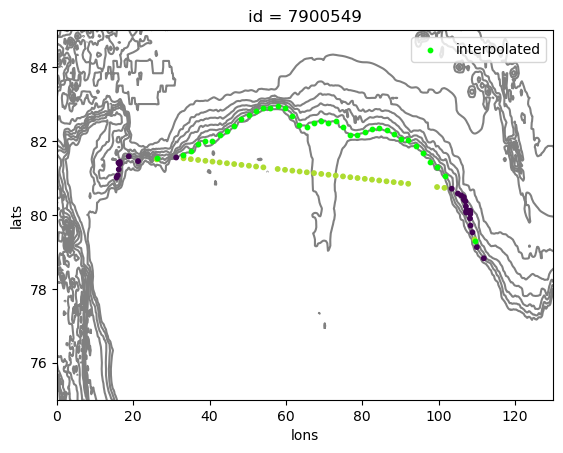

In [5]:
# https://github.com/euroargodev/terrain-following/blob/main/interpolation_v2.py
# interpolation_v2
# %%
import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt

'''
This sctipt estimates under-ice Argo tragectries assuming barotropic PV conservation,
by interpolating depths which is determined by the position-known end points of a interpolation section.
(by Kaihe Yamazaki, September 14, 2017.)
'''

### set tuning parameters
Range = 0.2 # estimate position between +/- 0.2 deg per cycle (length of search range)
dGrid = 1/60 # grid size of the ambient PV data (deg)

rsl = 2 # resolution of position estimation
# rsl=1: 1/60 deg, 25 points(finest)
# rsl=2: 1/30 deg, 13 points
# rsl=3: 0.05 deg, 9 points

### load trajectry data
df = pd.read_csv('traj_processed.csv')
# df.columns --> Index(['Unnamed: 0', 'id', 'cast', 'qpos', 'lons', 'lats', 'juld'], dtype='object')
# 'qpos' is position quality flag originally named as 'POSITION_QC'

'''
According to the positioning flag attached to each profile, the Argo data were categorized into two groups: "accurately positioned data" and "position-lacking data".
The former is data with a position quality flag of either 1: "good data" or 2: "probably good data", while the latter is data whose position quality flag is neither 1 nor 2 (without accurate position)
Most of the position-lacking data have linearly interpolated positions (with position quality flag being 8: "interpolated") and are located within the seasonal ice zone.
Here, positions of "position-lacking data" are interpolated following PV contours.
'''

### install topographic(ambient PV) data
data = netCDF4.Dataset('GRIDONE_1D.nc')
topo = data.variables['z'][:].reshape(10801,21601)
dxg = 1/60; xg = np.arange(-180,180+dxg,dxg)# in degree
dyg = 1/60; yg = np.arange(-90,90+dyg,dyg)
def getDepth(lon,lat,topo,message=False): # this function returns distance-weighted average of depths
    if lon >= 180:
        ilon = int((lon-180)/dxg)
        dlon = (lon-180) - ilon*dxg
    else:
        ilon = int((lon+180)/dxg)
        dlon = (lon+180) - ilon*dxg
    ilat = int((90-lat)/dyg)
    dlat = (90-ilat*dyg) - lat
    if ilon==21600: # e.g. lon = 179.99..
        Znw = topo[ilat,ilon];   Zne = topo[ilat,0]
        Zsw = topo[ilat+1,ilon]; Zse = topo[ilat+1,0]
    else:
        Znw = topo[ilat,ilon];   Zne = topo[ilat,ilon+1]
        Zsw = topo[ilat+1,ilon]; Zse = topo[ilat+1,ilon+1]
    w = np.array([(dxg-dlon)*(dyg-dlat),(dxg-dlon)*dlat,dlon*(dyg-dlat),dlon*dlat])
    return np.average([Znw,Zne,Zsw,Zse], weights=w)

# %% main code
ids = np.unique(df.id)
dfs = []
spans = []
for idi in ids:
    dfi = df[df.id==idi].sort_values('cast')
    dfi['ilon']=0.0; dfi['ilat']=0.0 # define interpolated coordinates
    dfi['span']=0.0
    # 'span' is the length of consecutive cycles to be interpolated
    dfi = dfi.reset_index(drop=True)

    # position that quality flag worse than 2 defined as a bad (position-lacking) data
    indxIntp = np.where(dfi.qpos>2)[0] # fetch index of bad data 
    ### For clarity, this line may be revised so as to fetch positioned data...
    
    if len(indxIntp)==0:
        continue
    
    discont = [] # search discontinuity in index list 'indxIntp' (e.g., index 1 in indxIntp = [1,2,4,5]; 3 is index of positioned data)
    for i in range(len(indxIntp)-1):
        if indxIntp[i+1] - indxIntp[i] > 1: # find discontinuity
            discont.append(i+1) # to be associated with i_bgn

    ### interpolate for every section between discontinuities
    ### 'i_bgn' and 'i_end' are the indices of the end of interpolation section (good data separated by consecutive bad data)
    for sect in range(len(discont)+1):
    
        if sect == 0:
            i_bgn = indxIntp[0] - 1 # good data at the ends of interpolation
        else:
            i_bgn = indxIntp[discont[sect-1]] - 1
        if i_bgn < 0: # for case the first cast is bad data
            continue
            
        if sect == len(discont):
            i_end = indxIntp[-1] + 1 # good data at the ends of interpolation
        else:
            i_end = indxIntp[discont[sect]-1] + 1
        if i_end > len(dfi)-1: # for case the last cast is bad data
            continue
        
        ######
        ### first, estimate by forwarding interpolation
        dfsec = dfi[i_bgn:i_end+1]
        dfsec = dfsec.reset_index(drop=True)

        lens = len(dfsec)
        if lens < 3: # check if bad data exist (maybe redundunt)
            continue
        span = lens-2 # length of under-ice cycles
        spans.append(span) # the length of malpositioned cycles

        x1 = dfsec.lons.values[0]; x2 = dfsec.lons.values[-1]
        y1 = dfsec.lats.values[0]; y2 = dfsec.lats.values[-1]
        z1 = getDepth(x1, y1, topo)
        z2 = getDepth(x2, y2, topo)
        dx = (x2 - x1)/(lens-1) # denominator is the number of sections between data points
        dy = (y2 - y1)/(lens-1)
        dz = (z2 - z1)/(lens-1) # PV will be linearly interpolated

        ### define search axis
        fact = np.cos(np.deg2rad((y1+y2)/2))
        dxf = dx/fact # convert to Cartesian coordinate
        def searchAxis(x,y,Lon): # this is normal to the trajectry (tangential) axis
            return -dxf/dy*(Lon-x)+y # return latitude

        # project to "x-direction" (note again, the search axis is normal to the tangential axis)
        slope = np.abs(dy / np.sqrt(dxf**2 + dy**2)) 
        Range_ = Range * slope
        dGrid_ = dGrid * slope

        ### estimate positions
        xref = x1; yref = y1
        for i in range(span):
            xi = xref + dx
            yi = yref + dy
            lonSearch = np.arange(xi-Range_, xi+Range_+dGrid_*rsl, dGrid_*rsl)
            latSearch = np.array([searchAxis(xi,yi,loni) for loni in lonSearch])
            # plt.plot(lonSearch,latSearch,lw=0.1,color='k')
            zi = z1 + dz*(i+1) # reference depth
            zref = np.array([getDepth(lonSearch[j], latSearch[j], topo)
                                for j in range(len(lonSearch))])
            indxRef = np.argmin(np.abs(zref - zi))
            dfsec.loc[i+1,"ilon"] = lonSearch[indxRef] # dfsec.ilon[i+1] = lonSearch[indxRef]
            dfsec.loc[i+1,"ilat"] = latSearch[indxRef] # dfsec.ilat[i+1] = latSearch[indxRef]
            xref = lonSearch[indxRef]; yref = latSearch[indxRef]

        ilons1 = dfsec.ilon.values # position obtained with forwarding interpolation
        ilats1 = dfsec.ilat.values 
        
        ######
        ### second, estimate by backwarding interpolation
        dfsec = dfi[i_bgn:i_end+1][::-1]
        dfsec = dfsec.reset_index(drop=True)

        lens = len(dfsec)
        if lens < 3: # check if bad data exist (maybe redundunt)
            continue
        span = lens-2 # length of under-ice cycles
        spans.append(span) # the length of malpositioned cycles

        x1 = dfsec.lons.values[0]; x2 = dfsec.lons.values[-1]
        y1 = dfsec.lats.values[0]; y2 = dfsec.lats.values[-1]
        z1 = getDepth(x1, y1, topo)
        z2 = getDepth(x2, y2, topo)
        dx = (x2 - x1)/(lens-1) # denominator is the number of sections between data points
        dy = (y2 - y1)/(lens-1)
        dz = (z2 - z1)/(lens-1) # PV will be linearly interpolated

        ### define search axis
        fact = np.cos(np.deg2rad((y1+y2)/2))
        dxf = dx/fact # convert to Cartesian coordinate
        def searchAxis(x,y,Lon): # this is normal to the trajectry (tangential) axis
            return -dxf/dy*(Lon-x)+y # return latitude

        # project to "x-direction" (note again, the search axis is normal to the tangential axis)
        slope = np.abs(dy / np.sqrt(dxf**2 + dy**2)) 
        Range_ = Range * slope
        dGrid_ = dGrid * slope

        ### estimate positions
        xref = x1; yref = y1
        for i in range(span):
            xi = xref + dx
            yi = yref + dy
            lonSearch = np.arange(xi-Range_, xi+Range_+dGrid_*rsl, dGrid_*rsl)
            latSearch = np.array([searchAxis(xi,yi,loni) for loni in lonSearch])
            zi = z1 + dz*(i+1) # reference depth
            zref = np.array([getDepth(lonSearch[j], latSearch[j], topo)
                                for j in range(len(lonSearch))])
            indxRef = np.argmin(np.abs(zref - zi))
            dfsec.loc[i+1,"ilon"] = lonSearch[indxRef] # dfsec.ilon[i+1] = lonSearch[indxRef]
            dfsec.loc[i+1,"ilat"] = latSearch[indxRef] # dfsec.ilat[i+1] = latSearch[indxRef]
            xref = lonSearch[indxRef]; yref = latSearch[indxRef]

        ilons2 = np.flipud(dfsec.ilon.values) # position obtained with backwarding interpolation
        ilats2 = np.flipud(dfsec.ilat.values) 

        ###
        ### get the average of forwarding/backwarding intepolations weighting by the distance from the end points
        lonBgn,latBgn = dfi[i_bgn:i_end+1].lons.values[0], dfi[i_bgn:i_end+1].lats.values[0]
        fact = np.cos(np.deg2rad(latBgn))
        distBgn1 = np.sqrt(((ilons1-lonBgn)/fact)**2 + (ilats1-latBgn)**2)
        distBgn2 = np.sqrt(((ilons2-lonBgn)/fact)**2 + (ilats2-latBgn)**2)

        lonEnd,latEnd = dfi[i_bgn:i_end+1].lons.values[-1],dfi[i_bgn:i_end+1].lats.values[-1]
        fact = np.cos(np.deg2rad(latEnd))
        distEnd1 = np.sqrt(((ilons1-lonEnd)/fact)**2 + (ilats1-latEnd)**2)
        distEnd2 = np.sqrt(((ilons2-lonEnd)/fact)**2 + (ilats2-latEnd)**2)

        weight1 = 1/distBgn1 + 1/distEnd1 # this shape of weighting function has some arbitrariness...
        weight2 = 1/distBgn2 + 1/distEnd2

        #dfi.ilon[i_bgn:i_end+1] = (ilons1*weight1 + ilons2*weight2)/(weight1 + weight2)        
        dfi.loc[i_bgn:i_end,"ilon"]= (ilons1*weight1 + ilons2*weight2)/(weight1 + weight2)
        #dfi.ilat[i_bgn:i_end+1] = (ilats1*weight1 + ilats2*weight2)/(weight1 + weight2)
        dfi.loc[i_bgn:i_end,"ilat"] = (ilats1*weight1 + ilats2*weight2)/(weight1 + weight2)

    dfs.append(dfi)

df = pd.concat(dfs)
df = df.sort_values(by='id').reset_index(drop=True)
# %% plot interpolated positions
xx,yy = np.meshgrid(xg[::10],yg[::10])
for idx in np.unique(df.id).astype('int'):
    df1 = df[df.id==idx]
    plt.contour(xx,yy,np.flipud(topo[::10,::10]),levels=np.arange(-5000,0,500),colors='gray',linestyles='-')
    plt.title('id = '+str(idx))
    plt.scatter(df1.lons,df1.lats,c=df1.qpos,s=10,zorder=2); plt.xlabel('lons'); plt.ylabel('lats')
    plt.scatter(df1.ilon,df1.ilat,c='lime',s=10,zorder=2,label='interpolated')
    plt.legend()
    plt.xlim(0,130); plt.ylim(75,85)
    plt.savefig(str(idx)+'_interpolated.png',dpi=200)
    plt.show()


From here forward is my own code.

## Saving the data in csv
Before exporting the data in csv format I order the cycles for them to be as in the original file. I order the lines, then create three new columns in the dataframe: flon and flat (final lon and lat positions) and nqpos (new corresponding quality flags for the positions). Finally I export the data in a csv file.

In [6]:
# here I order by WMO number (one can run the script for several floats but that is to complicated for me atm)
df = df.sort_values(by=['id','cast','juld'])

# create a vector with the new position QC
indx = np.where(df.ilat>0)[0]
nqpos=df.qpos.to_numpy()
nqpos[indx]=8
df['fqpos']=nqpos
#print(nqpos)

# create a vector with the best lon, lat
flon=df.ilon.to_numpy() #copy the interpolated
olon=df.lons.to_numpy() #copy the interpolated
indx = np.where(df.ilat==0)[0] #if there is no interpolated
flon[indx]=olon[indx]
df['flon']=flon
#print(flon)

flat=df.ilat.to_numpy() #copy the interpolated
olat=df.lats.to_numpy() #copy the interpolated
indx = np.where(df.ilat==0)[0] #if there is no interpolated
flat[indx]=olat[indx]
df['flat']=flat
#print(flat)

#print(df)
df.to_csv('TrajectoryCSVinterppos_'+str(idx)+'.csv')

## Modifying the netcdf file 


In [7]:
dset = netCDF4.Dataset(names[0], 'r+')
dset.variables['LONGITUDE'][:]= flon
dset.variables['LATITUDE'][:]=flat;
#dset['LONGITUDE'][:]=flon;

qpos =dset['POSITION_QC'][:]

for i in range(0,len(nqpos)):
  qpos[i]=nqpos[i].astype('|S1')

dset.variables['POSITION_QC'][:]=qpos;
dset.close()

Here I proof that the new data are stored in the netcdf

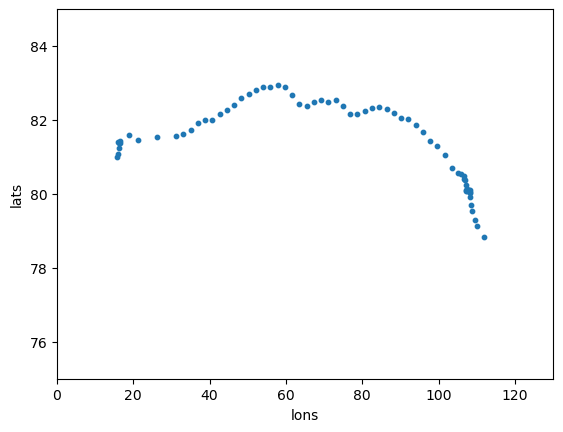

In [8]:
names = glob.glob('*_prof.nc')
names.sort()
dset = netCDF4.Dataset(names[0])

plt.scatter(dset.variables['LONGITUDE'][:],dset.variables['LATITUDE'][:],s=10,zorder=2); plt.xlabel('lons'); plt.ylabel('lats')
plt.xlim(0,130); plt.ylim(75,85)
#plt.savefig(str(idx)+'_interpolated.png',dpi=200)
plt.show()